In [56]:
import pickle
import lzma
import pandas as pd
import numpy as np
import random
import itertools
import requests
import parmap
from numpy.random import rand
from random import randint
import joblib 
from joblib import Parallel, delayed
import contextlib
import warnings
from tqdm import tqdm  
import seaborn as sns
warnings.filterwarnings("ignore")

In [57]:
# import function for 

In [3]:
# function for calculating entropy
def entro_cal(mat_prop,ts_cal):
    
    #mat_prop: averaged protein activities across time
    #ts_cal: simulated time step
    
    #prep data
    en_ = mat_prop.copy()
    en_.columns = [cl_ for cl_ in range(en_.shape[1])]   
    list_ = ["".join(map(str, list(en_[col])))for col in range(ts_cal)]
    en_2 = pd.DataFrame({"S":list_}).groupby("S").size().reset_index().rename({0:"CNT"},axis=1)["CNT"]
    en_3 = np.array(en_2)

    # entropy calculation
    prob_ = en_3/ts_cal
    log_p = np.log2(prob_)
    entropy_ = -sum([prob_[_] * log_p[_] for _ in range(len(log_p))])
    return entropy_


# function for generating cell line specfic profile from gene expresion and mutation data
def cell_line_profile (**args):
    
    
    globals().update(args)

    """
    1.1 Prep. File
    """
    # 1.1 gene expression: initial state
    ex_tmp = mdf_gx_final.query("cl == @cl_name").iloc[:,[1,2]]
    ex_tmp.columns = ["target","state"]
    ex_tmp["state"] = [int(np.random.choice([0,1], 1, p=[1-ex_tmp.iloc[i,1],ex_tmp.iloc[i,1]])) for i in range(ex_tmp.shape[0])]


    # 1.2 mutation : fix at Boolean function
    cl_tmp = cl_mut_.query("cl == @cl_name")[["target","value"]].drop_duplicates() 
    cl_tmp.columns = ["target","state"]

    dict_omic = {"ex_tmp":ex_tmp,
                 "cl_tmp":cl_tmp}

    rule_ran = [dict_omic[x] for x in hyp_rule]
    init_ran = [dict_omic[x] for x in hyp_init]   


    """
    1.2 mutation : fix at Boolean function
    """

    select_ = pd.concat(rule_ran).groupby(['target']).agg({'state': 'max'}).reset_index().query("target == @gene_list")
    exs_list = select_["target"].tolist()
    bool_cl = boolean_function.query("target != @exs_list")
    bool_cl_fixed = pd.concat([bool_cl, select_]).groupby(['target']).agg({'state': 'max'}).reset_index()


    #reorder row of protein
    bool_cl_fixed.target = bool_cl_fixed.target.astype("category")
    bool_cl_fixed.target.cat.set_categories(gene_list, inplace=True)
    bool_cl_fixed = bool_cl_fixed.sort_values(["target"])



    """
    1.3  gene expression: generate initial state 
    """

    init_gx = pd.concat(init_ran).groupby(['target']).agg({'state': 'max'}).reset_index().query("target == @gene_list").query("target != @exs_list")
    all_list = init_gx['target'].tolist()
    remain = boolean_function.query("target != @all_list")
    #the initial state any protien without information in gene expression will be randomly selected 1 or 0.
    remain["state"] = [int(np.random.choice([0,1], 1, p=[0.5,0.5])) for i in range(remain.shape[0])]
    final_init_state = pd.concat([init_gx,remain,select_]).groupby(['target']).agg({'state': 'max'}).reset_index()

    #reorder row of protein
    final_init_state.target = final_init_state.target.astype("category")
    final_init_state.target.cat.set_categories(gene_list, inplace=True)
    initial_state = final_init_state.sort_values(["target"])

    res_final = [initial_state,bool_cl_fixed]



    return res_final


# function for generating drug profile based on dose
def assign_rule_drug(**args):

    globals().update(args)
    
    gene_name_v2 =  fl.parse(0).iloc[:,:2]
    gene_name_v2.columns = ["protein","cn"] 

    #cell line - Boolean Rule fixed by genetic mutation
    boolean_rule = cell_line_profile(**args)[1].reset_index().iloc[:,1:]

    #drug row
    tg_drug_row = drug_target.query("drug  == @drug_1")
    tg_drug_row_ = pd.merge(gene_name_v2,tg_drug_row,on="protein").query("cn == @gene_list")

    #drug col
    tg_drug_col = drug_target.query("drug  == @drug_2")
    tg_drug_col_ = pd.merge(gene_name_v2,tg_drug_col,on="protein").query("cn == @gene_list")


    def dose_range(dose_):

        #dose of each drug
        dose_1st_drug = dose_[0]
        dose_2nd_drug = dose_[1]

        #assign drug
        def assign_drug(df,dose):
            
            #check which drug target is ON and OFF based on the dose probability 
            nrow_dr = df.shape[0]
            df["response_adj"] = [int(np.random.choice([0,1], 1, p=[1-dose,dose])) for i in range(nrow_dr)]
            #target will be perturbed by drug if it is equal to 1 which is based on probability.
            pow_dr = df.query("response_adj == 1")

            
            if (True in pow_dr.drug.str.contains('391210-10-9').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'MEK_i', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('915019-65-7').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'PI3K_c', 'response_adj'] = 0
                pow_dr.loc[pow_dr['cn'] == 'MTORC1_c', 'response_adj'] = 0
                pow_dr.loc[pow_dr['cn'] == 'MTORC2_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('ALPELISIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'PI3K_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('ANTIBIOTIC AY 22989').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'MTORC1_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('AZD2014').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'MTORC1_c', 'response_adj'] = 0
                pow_dr.loc[pow_dr['cn'] == 'MTORC2_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('AZD5363').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'AKT_i', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('BUPARLISIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'PI3K_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('CELECOXIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'PDPK1', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('DASATINIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'SRC', 'response_adj'] = 0
                pow_dr.loc[pow_dr['cn'] == 'LCK', 'response_adj'] = 0
                pow_dr.loc[pow_dr['cn'] == 'ABL1', 'response_adj'] = 0
                pow_dr.loc[pow_dr['cn'] == 'ABL2', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('DEFOROLIMUS').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'MTORC1_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('EMCYT').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'ESR1', 'response_adj'] = 1

            if (True in pow_dr.drug.str.contains('ENZASTAURIN').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'AKT_i', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('ERLOTINIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'EGFR', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('ERLOTINIB HYDROCHLORIDE').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'EGFR', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('FULVESTRANT').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'ESR1', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('GEFITINIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'EGFR', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('GELDANAMYCIN').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'HSP90AA1', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('IMATINIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'ABL1', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('LAPATINIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'EGFR', 'response_adj'] = 0
                pow_dr.loc[pow_dr['cn'] == 'HER2', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('MEGESTROL ACETATE').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'PGR', 'response_adj'] = 1

            if (True in pow_dr.drug.str.contains('MITOTANE').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'ESR1', 'response_adj'] = 1

            if (True in pow_dr.drug.str.contains('MK-2206').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'AKT_i', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('MK-8669').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'MTORC1_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('NILOTINIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'ABL1', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('NSC733504').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'MTORC1_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('PACLITAXEL').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'BCL2', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('PF-04691502').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'PI3K_c', 'response_adj'] = 0
                pow_dr.loc[pow_dr['cn'] == 'MTORC1_c', 'response_adj'] = 0
                pow_dr.loc[pow_dr['cn'] == 'MTORC2_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('RALOXIFENE').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'ESR1', 'response_adj'] = 1

            if (True in pow_dr.drug.str.contains('RUXOLITINIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'JAK2', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('SAPITINIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'HER2', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('SELUMETINIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'MEK_i', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('SORAFENIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'EGFR', 'response_adj'] = 0
                pow_dr.loc[pow_dr['cn'] == 'RAF1', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('STATTIC').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'STAT3', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('TAMOXIFEN CITRATE').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'ESR1', 'response_adj'] = 0
                pow_dr.loc[pow_dr['cn'] == 'MAPK8', 'response_adj'] = 1

            if (True in pow_dr.drug.str.contains('TEMSIROLIMUS').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'MTORC1_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('TRAMETINIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'MEK_i', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('TRISENOX').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'JUN', 'response_adj'] = 1
                pow_dr.loc[pow_dr['cn'] == 'CYCLIN_D_c', 'response_adj'] = 0
                pow_dr.loc[pow_dr['cn'] == 'ERK_i', 'response_adj'] = 1
                pow_dr.loc[pow_dr['cn'] == 'AKT_i', 'response_adj'] = 1

            if (True in pow_dr.drug.str.contains('VANDETANIB').tolist()) == True:
                pow_dr.loc[pow_dr['cn'] == 'EGFR', 'response_adj'] = 0

            return pow_dr
        

        #combine drug effect from both drug
        cdrug2 = pd.concat([assign_drug(tg_drug_row_, dose_1st_drug),
                   assign_drug(tg_drug_col_, dose_2nd_drug)])[["cn","response_adj"]]

        #### drug conflict ----> inhibitor always win 
        conflict_ = cdrug2.groupby("cn").mean().query("response_adj == 0.5").reset_index()["cn"].tolist()
        cdrug_filter = cdrug2.query("cn != @conflict_") 
        select_df = cdrug2.query("cn == @conflict_ and response_adj != 1")
        cdrug = pd.concat([select_df,cdrug_filter])

        ####

        cdrug.columns = ["target","state"]

        if cdrug.shape[0] == 0:
            final_adjs = boolean_rule.copy()
            df = final_adjs.set_index('target')
            final_adj = df.loc[gene_list].reset_index()
            final_adj["dose_row"] = dose_1st_drug
            final_adj["dose_col"] = dose_2nd_drug

            return final_adj.drop_duplicates()

        else:            
            bc_ = boolean_rule.query("target != @cdrug.target.tolist()")
            final_adjs = pd.concat([bc_,cdrug.drop_duplicates()])
            df = final_adjs.set_index('target')
            final_adj = df.loc[gene_list].reset_index()
            final_adj["dose_row"] = dose_1st_drug
            final_adj["dose_col"] = dose_2nd_drug

            return final_adj

    # generate Boolean rule across dose ranges
    res = [dose_range(_)["state"].tolist() for _ in big_mat_]

    return res



def asyn_inhibitor_opt(**args):
    

    globals().update(args)       
    time_step_ = elbow + 5000
    time_treat_drug_ = elbow
  
    
    res = [init_idx_]
    init_idx_2 = init_idx_.copy()
    
    
    for j in range(time_step_):

        ran_num = random.randint(0, len(bool_)-1)
        
        if j < time_treat_drug_:
            
            if j == 0:
            
                update_ = np.array([eval(bool_[x],init_)*1 for x in range(len(bool_))])
                bget = np.append(np.array([i for i, x in enumerate(bool_) if x == "1" or x == "0"]),ran_num).astype(int)
                init_idx_2[bget]= update_[bget]
                res.append(init_idx_2)
            
            else:
                
                val = np.array(res[j])
                update_ = dict(zip(keys_idx_, val))
                update_step = [eval(bool_[x],update_)*1 for x in range(len(bool_))]
                val[ran_num]= update_step[ran_num] 
                res.append(val)
            
        else:
            
            val_2 = np.array(res[j])
            idx_drug_fixed = np.array([i for i, x in enumerate(bool_treat_drug_) if x == "1" or x == "0" or x == 1 or x == 0]).astype(int)
            val_2[idx_drug_fixed] = bool_treat_drug_[idx_drug_fixed] 
            update_drug = dict(zip(keys_idx_,val_2))
            update_drug_step = np.array([eval(bool_treat_drug_[x],update_drug)*1 for x in range(len(bool_))])  
            val_2[ran_num]= update_drug_step[ran_num]
            res.append(val_2)
            
            
    return res


def get_para(reps,**args):
    
    bl_cl = cell_line_profile(**args)[1].reset_index().iloc[:,1:]
    
    init_cl = cell_line_profile(**args)[0].reset_index().iloc[:,1:]
    
    bool_ = [str(x) for x in sum(bl_cl[["state"]].to_numpy().tolist(),[])]
    
    init_ = dict(init_cl[["target","state"]].values)
    
    keys_idx = list(init_.keys())
    
    init_idx = np.array([init_.get(x) for x in keys_idx])

    #boolean function perturbed by drug
    drug_rule_ = assign_rule_drug(**args)
    
    
    dict_list = []
    
    for j in range(len(drug_rule_)):
    
        all_parameter = {"bool_":bool_,
                         "init_":init_,
                         "keys_idx_": keys_idx,
                         "init_idx_":init_idx,
                         "bool_treat_drug_": np.array(drug_rule_[j]), 
                         "elbow":SS[cl_name]}    
        
        dict_list.append(all_parameter)
        

    return dict_list



In [4]:
# read Boolean funciton from selected cell line
fl = pd.ExcelFile("data/GRN.xls")
boolean_function = fl.parse(1).iloc[:,:2] 
gene_list = boolean_function['target'].tolist()

gene_name =  fl.parse(0).iloc[:,:2]
gene_name.columns = ["HGNC","model_name"] 

drug_target = pd.read_csv("data/drug_target.csv")
read_out = ["CYCLIN_D_c","MTORC1_c","ESR1","BCL2","PAK1","STAT3","PGR","WNT1","P21","CASP3","GATA3","FADD","BID"]


In [5]:
#gene expression
cl_name = ["MCF7","T47D","BT549","MDAMB436","MDAMB231","MDAMB468"]
mdf_gx = pd.read_csv("data/omics/gx_fpkm_sanger_broad.csv.gz").iloc[:,1:].query("cl == @cl_name").rename({"variable":"HGNC"},axis=1)
mdf_gx_ = pd.merge(mdf_gx,gene_name,on="HGNC")[["cl","model_name","value"]]
mdf_gx_final = mdf_gx_.groupby(['cl','model_name']).agg({'value': 'mean'}).reset_index()
mdf_gx_final.columns = ["cl","target","value"]

#genetic mutation
cl_mut = pd.read_csv("data/omics/mutations_sanger_broad.csv.gz").iloc[:,1:].rename({"gene":"HGNC"},axis=1)
cl_mut_ = pd.merge(cl_mut,gene_name,on="HGNC")[["displayName","model_name","status"]]
cl_mut_.columns = ["cl","target","value"]


In [6]:
# matrix for simulation
big_mat_ = []
for f_dose in [0,0.25,0.75,1]:
    for s_dose in [0,0.25,0.75,1]:
        col = [f_dose,s_dose]
        big_mat_.append(col)      


In [7]:
# omics profile used for cell line 
rule_idx = pd.DataFrame([[["cl_tmp"],["ex_tmp"],"MCF7"],
[["cl_tmp"],["ex_tmp"],"T47D"],
[["cl_tmp"],["ex_tmp"],"MDAMB231"],
[["cl_tmp"],["ex_tmp"],"MDAMB468"],
[["cl_tmp"],["ex_tmp"],"BT549"]],columns=["rule","init","cl"])


In [8]:
#time step
ts = 5000
#number of repeats
simr = 5
cell_line = "MCF7"
rand_bool = rule_idx.query("cl == @cell_line").iloc[0,0]
rand_init = rule_idx.query("cl == @cell_line").iloc[0,1]

#an example of AKT inhibitor (AZD5363) and ESR1 inhibitor (FULVESTRANT) in MCF7 cell line
args = {"cl_name":cell_line,
        "hyp_rule":rand_bool,
        "hyp_init":rand_init,
        "drug_1":"AZD5363",
        "drug_2":"FULVESTRANT"}

#steady state
SS = {"MCF7":3500,
      "T47D":2750,
      "MDAMB231":2250,
      "MDAMB468":3500,
      "BT549":3500}


In [9]:

print("---Prepating filr ---")
# prepare cell-line-specific booolean rule and initial state through 5 simulations
all_set = Parallel(n_jobs=-1,backend="threading")(delayed(get_para)(i,**args) for i in range(simr))

print("---simulating ---")
# drug perturb simulation
df_list = []
for count, j in enumerate(all_set):
    print("run----->  "+str(count)+ " repeat")
    set_ = Parallel(n_jobs=-1,backend="threading")(delayed(asyn_inhibitor_opt)(**k) for k in tqdm(j))
    df_list.append(set_)

---PREP done !!! ---
---simulating ---
run----->  0 repeat


100%|██████████| 16/16 [00:57<00:00,  3.58s/it]


run----->  1 repeat


100%|██████████| 16/16 [01:18<00:00,  4.93s/it]


run----->  2 repeat


100%|██████████| 16/16 [01:58<00:00,  7.42s/it]


run----->  3 repeat


100%|██████████| 16/16 [00:26<00:00,  1.66s/it]


run----->  4 repeat


100%|██████████| 16/16 [00:34<00:00,  2.18s/it]


In [12]:
#summarize result
res_list = []
for reps,j in enumerate(df_list):
    for k in range(len(big_mat_)):
        df_cat = pd.DataFrame(j[k])
        df_cat_2 = df_cat.T
        df_cat_2.index = gene_list
        df_cat_2["dose"] = '_'.join(map(str, big_mat_[k]))
        df_cat_2["repeats"] = reps
        res_list.append(df_cat_2)

In [13]:
df_ = pd.concat(res_list)
df_["protein"] = df_.index
df_2 = df_.groupby(["dose","protein"]).mean().reset_index()

In [14]:
df_3 = df_2.drop(["repeats"],axis=1).melt(id_vars=["dose","protein"])
ss = np.max(df_3.variable.unique())-1000
df_4 = df_3.query("variable >= @ss")

In [15]:
df_5 = df_4.query("protein == @read_out").groupby(["dose","protein"]).mean().reset_index()

In [50]:
df_6 = df_5.groupby("protein").mean().reset_index()
df_7 = df_6.set_index('protein')
df_8= df_7.reindex(read_out)
df_9 = df_8.reset_index()

Text(0.5, 1.0, 'HSA synergy score = 4.06')

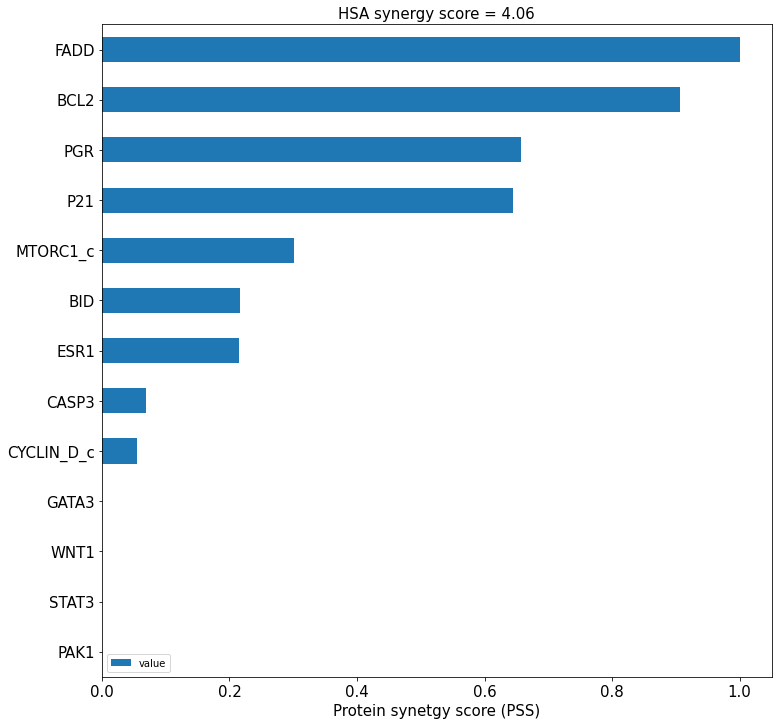

In [55]:
title = "HSA synergy score = "+str(np.round(df_9.value.sum(),2))
ax = df_9.sort_values(by="value").plot.barh(x="protein",y='value', rot=0,figsize=(12,12),fontsize=15)
ax.set_xlabel("Protein synetgy score (PSS)",fontdict={'fontsize':15})
ax.set_ylabel("")
ax.set_title(title,fontdict={'fontsize':15})